In [1]:
import os
import h5py
import numpy
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime
import pandas as pd
import time
from scipy.signal import savgol_filter
import scipy.signal as signal

In [2]:
def timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromtimestamp(i) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def zscore(array):
    mean = array.mean()
    std = np.std(array)
    return((array-mean)/std)

def ms_from_start(datetimes):
    return(((datetimes-datetimes[0])/1000).astype(np.float64))

def get_mean_brightness(h5file, inds):
    lefts, rights = [], []
    for ind in inds:
        left = cv2.imdecode(h5file['left'][ind],0)
        right =  cv2.imdecode(h5file['right'][ind],0)
        lefts.append(left.mean())
        rights.append(right.mean())
    return(np.vstack((lefts, rights)).mean(axis=0))

def smooth(array, window_size=5):
    assert(window_size%2==1)
    filt = np.ones(window_size)/window_size
    # print(filt.sum())
    assert(abs(filt.sum()-1)<1e-6)
    
    return(np.convolve(array,filt, mode='same'))

def calculate_hist(array,binedges):
    binedges[0] = -np.inf
    binedges[-1] = np.inf
    histogram, bin_edges = np.histogram(array,binedges)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    return(histogram,bincenters)

def align_cameras_on_timestamps(filelist,master='right_post', WINDOW_SIZE=500,
                               use_window=True):
    # WINDOW_SIZE=500
    max_distance = 6 # ms
    
    frames = {}
    timestamps = {}
    sestimes = {}
    # filelist.sort()
    for key, file in filelist.items():
        if not file.endswith('t.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
            sestime = f['sestime'][:]
        # key = os.path.basename(file)[:-3]
        frames[key] = framecounts
        timestamps[key] = timestamp
        sestimes[key]  = sestime
    N = min(len(frames[master]), len(timestamps[master]))
    camera_LUT = np.array((N,len(frames)), dtype=np.uint64)
    slaves = [i for i in list(frames.keys()) if i!=master]
    camera_LUT = np.zeros((N,len(frames)), dtype=np.float64)
    
    for i in range(0,N):
        camera_LUT[i,0] = i
        t = timestamps[master][i]
        min_search = max(0,i-WINDOW_SIZE)
        
        for j, slave in enumerate(slaves):
            max_search = min(len(frames[slave]),i+WINDOW_SIZE)
            # happens when there are large differences in numbers of images between two files
            # this likely means the master has way more images than the slave
            if max_search==min_search:
                camera_LUT[i,j+1]=np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)
                
            else:
                snippet = np.abs((timestamps[slave]-t).astype(np.float32)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            
            if mint < max_distance:
                val = argmin + min_search
            else:
                val = np.nan
            
            camera_LUT[i,j+1] = val
    
    # data = np.hstack((camera_LUT, timestamps[master]))
    df = pd.DataFrame(camera_LUT, columns=[master]+slaves)
    df['timestamps'] = timestamps[master]
    
    return(df)

def get_frames_by_index(camfiles, LUT, index, blank_frame=False, shape=(270,480)):
    lefts = []
    rights = []
    row = LUT.iloc[index,:]
    t = np.datetime64(row['timestamps'])
    for camname, file in camfiles.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            with h5py.File(file, 'r') as f:
                left = cv2.imdecode(f['left'][camind],0)
                right = cv2.imdecode(f['right'][camind],0)
        else:
            if blank_frame:
                if len(lefts)> 0:
                    left = np.zeros_like(lefts[0])
                    right = np.zeros_like(rights[0])
                else:
                    left = np.zeros(shape, dtype=np.uint8)
                    right = np.zeros(shape, dtype=np.uint8)
            else:
                left, right = None, None
        lefts.append(left)
        rights.append(right)
            
    return(lefts, rights)

In [3]:
datadir = r'/media/jim/FASTER/realsense/190326/JB043_large_750us_1050mALEDs_194226_174210'

In [4]:
cams = ['left_ant', 'left_post', 'right_ant','right_post']

camfiles = os.listdir(datadir)
camfiles.sort()
camfiles = {os.path.basename(i)[:-3]: os.path.join(datadir,i) for i in camfiles if i.endswith('t.h5')}

LUT = align_cameras_on_timestamps(camfiles)

In [5]:
LUT

,right_post,left_ant,left_post,right_ant,timestamps
0,0.0,NaN,NaN,NaN,2019-03-26 17:42:12.989580
1,1.0,NaN,NaN,NaN,2019-03-26 17:42:13.022930
2,2.0,NaN,NaN,NaN,2019-03-26 17:42:13.039653
3,3.0,NaN,NaN,NaN,2019-03-26 17:42:13.056303
4,4.0,NaN,NaN,NaN,2019-03-26 17:42:13.073076
5,5.0,NaN,NaN,NaN,2019-03-26 17:42:13.089685
6,6.0,NaN,NaN,NaN,2019-03-26 17:42:13.106303
7,7.0,NaN,NaN,NaN,2019-03-26 17:42:13.123018
8,8.0,NaN,NaN,NaN,2019-03-26 17:42:13.139787
9,9.0,NaN,NaN,NaN,2019-03-26 17:42:13.156393


In [11]:
syncfile = [os.path.join(datadir, i) for i in os.listdir(datadir) if i.endswith('0001.h5')][0]
print(syncfile)

/media/jim/FASTER/realsense/190326/JB043_large_750us_1050mALEDs_194226_174210/JB043_2019-03-26_0001.h5


In [42]:
with h5py.File(syncfile, 'r') as f:
    digital_scans = f['sweep_0001/digitalScans'][:]
    sync_timestamp = f['sweep_0001/timestamp'][:]
    header = f['header']
    header_keys = list(f['header'].keys())
    header_dict = {}
    for key in header_keys:
        try:
            header_dict[key] = f['header'][key][:]
        except Exception as e:
            print('Exception with key %s: '%key, e)
    # header_dict = {key:f['header'][key][:] for key in header_keys}
    # print()
    # print(f)
    print(digital_scans.shape)
    print(digital_scans[:,:10])

Exception with key AITerminalIDsOnEachDevice:  'slice' object has no attribute 'encode'
Exception with key LayoutForAllWindows:  'slice' object has no attribute 'encode'
Exception with key StimulusLibrary:  'slice' object has no attribute 'encode'
(1, 74979106)
[[0 0 0 0 0 0 0 0 0 0]]


In [41]:
74979106/header_dict['AcquisitionSampleRate']/60

array([[12.49651767]])

In [38]:
digital_scans

{'AIChannelDeviceNames': array([b''], dtype=object),
 'AIChannelNames': array([b''], dtype=object),
 'AIChannelScales': array([[0.]]),
 'AIChannelTerminalIDs': array([[0.]]),
 'AIChannelTerminalNames': array([b''], dtype=object),
 'AIChannelUnits': array([b''], dtype=object),
 'AIScalingCoefficients': array([[0.]]),
 'AOChannelDeviceNames': array([b''], dtype=object),
 'AOChannelNames': array([b''], dtype=object),
 'AOChannelScales': array([[0.]]),
 'AOChannelTerminalIDs': array([[0.]]),
 'AOChannelTerminalNames': array([b''], dtype=object),
 'AOChannelUnits': array([b''], dtype=object),
 'AbsoluteProtocolFileName': array([b'C:\\Users\\Behavior-Jim\\Documents\\MATLAB\\MousePad\\realsense_with_virmen.cfg.wsp'],
       dtype='|S77'),
 'AbsoluteUserSettingsFileName': array([b''], dtype=object),
 'AcquisitionSampleRate': array([[100000.]]),
 'AcquisitionTriggerIndex': array([[1.]]),
 'ActiveInputChannelIndexFromInputChannelIndex': array([[1.],
        [2.]]),
 'AllChannelNames': array([b'P

In [51]:
plt.style.use('ggplot')

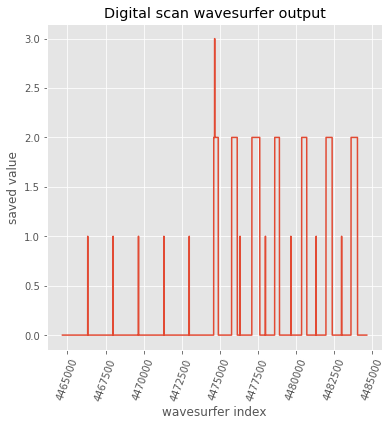

In [55]:
index = np.argmax(digital_scans)
window = 10000

indices = range(index-window, index+window)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(indices, digital_scans[0, indices])
ax.set_xlabel('wavesurfer index')
ax.set_ylabel('saved value')
ax.set_title('Digital scan wavesurfer output')
plt.xticks(rotation=70)
plt.show()

In [56]:
channel_one = (np.logical_or(digital_scans==1,digital_scans==3)).astype(np.uint8)
channel_two = (np.logical_or(digital_scans==2,digital_scans==3)).astype(np.uint8)

In [58]:
print(len(LUT))

43675


In [59]:
np.sum(np.diff(channel_one)==1)

43764

In [60]:
np.sum(np.diff(channel_two)==1)

41633

In [70]:
index

4474667

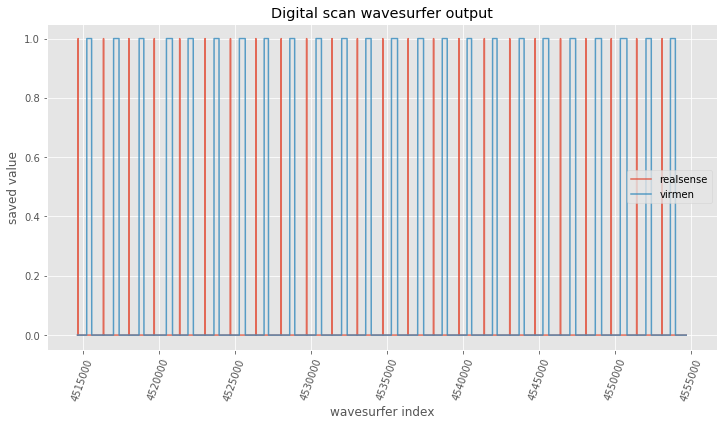

In [76]:
# index = np.argmax(digital_scans)
index = 4474667+60000
window = 20000

indices = range(index-window, index+window)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(indices, channel_one[0, indices], label='realsense',alpha=0.8)
ax.plot(indices, channel_two[0, indices], label='virmen',alpha=0.8)
ax.set_xlabel('wavesurfer index')
ax.set_ylabel('saved value')
ax.set_title('Digital scan wavesurfer output')
ax.legend()
plt.xticks(rotation=70)
plt.show()

# Strategy for alignment
* Use the timestamp field + sample rate to get rough timestamps for onsets
* Use rough timestamps to find "missing" frames, usually 1-2 per field. This is an uptick without an associated file
* Assign the rest of the frames, in order, to the upticks. This is huge--this is aligning all the cameras to the voltage signal!
* For every virmen frame, find the nearest frame in time (exclusive!!). This is our ultimate alignment

# Verify alignment
* Rewards should coincide with little movement
* Frame-to-frame mean brightness change should have a high cross-correlation with absolute ball signal
* EXPERIMENT: turn virmen on, plug and unplug LEDs. Do this after I have saving for Flea camera down

In [64]:
datadir

'/media/jim/FASTER/realsense/190326/JB043_large_750us_1050mALEDs_194226_174210'